In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('E:/competations/clusterAnalysis/data.csv', encoding='unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
data.shape

(541909, 8)

In [4]:
(data.isna().sum()/data.shape[0])*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

                       DATA PREPROCESSIG and FEATURE ENGINEERING 
1. DATA COMPLETENESS -HANDLE MISSING VALUES
we have an option to drop missing values. However, to ensure data completeness let's fill them with some values. 
Description- we will fill this with 'UNKNOWN' 
CustomerID- we fill this with the corresponding InvoiceNo. These two columns have unique value and show a different pattern. Therefore we can be sure there is no chance of duplicating a customer ID.

In [5]:
data['CustomerID']=data.CustomerID.fillna(data.InvoiceNo)
data['Description']=data.Description.fillna('UNKNOWN')
(data.isna().sum()/data.shape[0])*100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

3. DATE
There is need to put InvoiceDate into a date format so we can derive other features from it.
Introduce a columns for day of the week, month and hour when the transaction was recorded, this will be usefull in analytics. Observing transaction dates and time, the shop operates from 8AM to 6PM. In my new date variable I dropped hour and minute, this column will be used to compute customers' age (difference between their first transaction date and last transaction date.

In [6]:
from dateutil import parser #this parser can only be applied to string
data['day']=data.InvoiceDate.apply(lambda x: parser.parse(x).strftime('%A'))
data['month']=data.InvoiceDate.apply(lambda x: parser.parse(x).strftime('%b'))
data['hour']=data.InvoiceDate.apply(lambda x: parser.parse(x).strftime('%I'))
data['InvoiceDate']=pd.to_datetime(data.InvoiceDate) #pick dates only and ignore time
data['InvoiceDate']=data['InvoiceDate'].dt.date

4. ORDER STATUS
This column indicates cancelled and completed transactions. It was derived from InvoiceNO feature where any invoiceNo starting with 'C' denotes cancelled transaction. This is important for our solution goal.

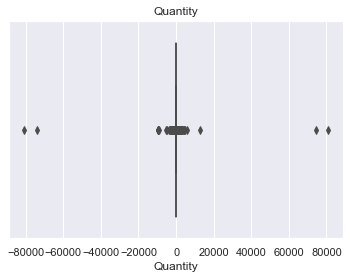

In [7]:
#quantity
sns.set_theme(style='darkgrid')
sns.boxplot(data.Quantity)
plt.title('Quantity')
plt.show()

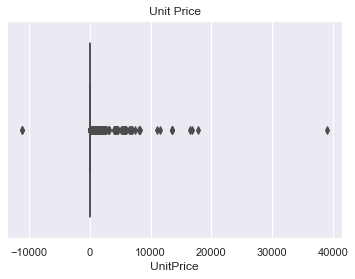

In [8]:
sns.boxplot(data.UnitPrice)
plt.title('Unit Price')
plt.show()

5. INDENTIFY and FIX OUTLIERS
we plot boxplots for Quantity and UnitPrice. My approach is rather unique here based on my assumptions of business case. Ever heard of "Do not use hammer to fix everything"? Replacing outliers with quantile values in every situation is akin using a hammer in every problem. In ideal situation we do not expect -ve quantity, however, in this business case -ve quantity is used for cancelled transaction.We cannot have -ve price since the quantity column takes care of cancelled transactions. We will see how this is important in the next few steps. 

My assumptions for this business case; 
Any quantity>600 is replaced with upper whisker value and quantity<-600 replaced by -10. Price<=0 is replaced by lower whisker value while price>500 is replaced by upper whisker value.see above boxplots.

In data science projects such assumptions should be discussed with stakeholders and decision makers at work, for this project I made the above decisons based on my observations from data, since no much details were provided by the data source. 



In [9]:
lowerq=data['Quantity'].quantile(0.05)
upperq=data['Quantity'].quantile(0.95)
data['Quantity']=data.Quantity.apply(lambda x: upperq if x>600 else x)
data['Quantity']=data.Quantity.apply(lambda x: -10 if x<-600 else x)

upperq=data['UnitPrice'].quantile(0.95)
lowerq=data['UnitPrice'].quantile(0.05)
data['UnitPrice']=data.UnitPrice.apply(lambda x: upperq if x>500 else x)
data['UnitPrice']=data.UnitPrice.apply(lambda x: lowerq if x<=0 else x)

In [10]:
data.describe() #confirm outliers are gone

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.241319,3.598472
std,25.892107,9.218827
min,-600.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,600.000000,498.790000


6. ORDER STATUS
Introduce a feature that tells whether a transaction went through or was cancelled, this is useful to identify cancelled transactions. Further we could investigate characteristics of cancelled transactions, in ideal business world the aim is to minimize cancelled deals. 

In [11]:
#create a column to indicate cancelled and completed transactions 
data['order_status']=data.InvoiceNo.apply(lambda x: 'cancelled' 
                                          if (x.startswith('C')) else 'Completed')


7. TOTAL VALUE of EACH TRANSACTION 
We multiply unit price by quantity to get total value of a transaction. This feature will be useful in computing monetary value of a customer. 

In [12]:
data['total_value']=data.Quantity * data.UnitPrice
data.total_value.head(3)

0    15.30
1    20.34
2    22.00
Name: total_value, dtype: float64

In [43]:
#write new data to csv file and name it customers 
data.to_csv('E:/competations/clusterAnalysis/customers.csv', index=False)

2. ANALYTICS 
Deriving actionable and useful insights is the number one objective of a data analytics project. In this case study graphs and tables were used to deliver useful information from raw data. Each graph or table output has a markdown interpreting the findings.  

1. summarize number of customers , transactions and items sold
8082 customers shopped with this retail store during the period. 
25900 transactions were recorded during the period.
4224 items were sold during the period.

Now imagine if we dropped null values, we could have lost a huge proportion of useful data. 

In [13]:
#summarize number of customers , unique products and number of transactions during the period
customers=len(data.CustomerID.value_counts())
transactions=len(data.InvoiceNo.value_counts())
items=len(data.Description.value_counts())
col=['customers', 'transactions','items']
summary=pd.DataFrame([{'customers':customers,'transactions':transactions,'items':items}],columns=col,index=['Counts'])
summary

,customers,transactions,items
Counts,8082,25900,4224


2. Visualize transaction/order status 
This gives clear information on what proportion was cancelled or completed.
98% of all recorded transactions were successful, while 2% were cancelled. 

We cannot conclude whether this is good for the business since no requirements were given by the data source, only the stakeholders of this retail shop can decide.

In my business point of view the number of cancelled transactions were high =9288, this means a loss to the business. What if the company could investigate reasons causing cancellation? Is it an issue with the product? Is it the price? etc. This would definitely increase profits and maybe maintain customers who would otherwise churn out. 

In [14]:
data.order_status.value_counts()

Completed    532621
cancelled      9288
Name: order_status, dtype: int64

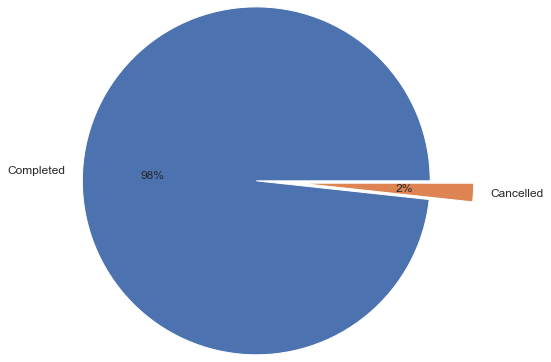

In [15]:
labels=['Completed', 'Cancelled']
props=data.order_status.value_counts()
explode=(0.5, 0)
plt.pie(props,labels=labels ,autopct='%.0f%%',textprops={'size': 'medium'},shadow=False, radius=2,explode=explode)
#plt.title('Transaction Status', size=18)
plt.show()

3. DAY of the WEEK versus TRANSACTIONS 
This summary give information on traffic for days of the week. There were no transctions on saturday , maybe the store does not operate on saturdays. Thursday and Tuesday recorded the highest number of transactions, looks like these two are busy days at the store. Sunday account for the smallest proportion 12% of all transactions. 

In [16]:
col=['InvoiceNo','day']
days=data[col]
temp=days.groupby('day', as_index=False).count().sort_values(by='InvoiceNo', ascending=False)
temp

,day,InvoiceNo
3,Thursday,103857
4,Tuesday,101808
1,Monday,95111
5,Wednesday,94565
0,Friday,82193
2,Sunday,64375


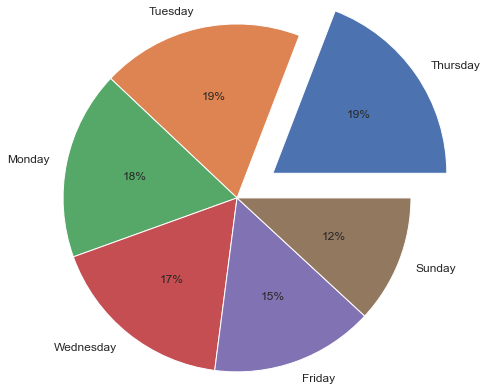

In [17]:
labels=temp.day
props=temp.InvoiceNo
explode=(0.5, 0,0,0,0,0)
plt.pie(props,labels=labels ,autopct='%.0f%%',textprops={'size': 'medium'},shadow=False, radius=2,explode=explode)
plt.show()

4. SALES VOLUME VERSUS MONTH
It's evident November is the best month for this business, accounting for 16% of the transactions. December follow closely accounting 13% of the sales, October is not that bad either recording 11%. July May,June,March and August each contibuted 7% of the sales. February is the worst for this business contributing 5%. January and April each contributing 6% of the sales. 

TIME SERIES PERSPECTIVE:

In [18]:
col=['InvoiceNo','month']
mons=data[col]
temp=mons.groupby('month', as_index=False).count().sort_values(by='InvoiceNo', ascending=False)
temp

,month,InvoiceNo
9,Nov,84711
2,Dec,68006
10,Oct,60742
11,Sep,50226
5,Jul,39518
8,May,37030
6,Jun,36874
7,Mar,36748
1,Aug,35284
4,Jan,35147


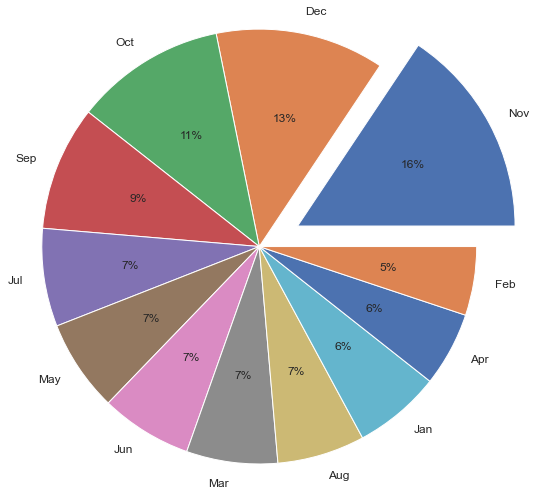

In [19]:
labels=temp.month
props=temp.InvoiceNo
explode=(0.5, 0,0,0,0,0,0,0,0,0,0,0)
plt.pie(props,labels=labels ,autopct='%.0f%%',textprops={'size': 'medium'},shadow=False, radius=2.5,explode=explode)
plt.show()

In [73]:
col=['InvoiceNo','hour']
hours=data[col]
temp=hours.groupby('hour', as_index=False).count().sort_values(by='InvoiceNo', ascending=True)
temp

,hour,InvoiceNo
6,07,4088
5,06,8015
7,08,9780
4,05,28509
8,09,34332
9,10,49037
3,04,54516
10,11,57674
1,02,67471
0,01,72259


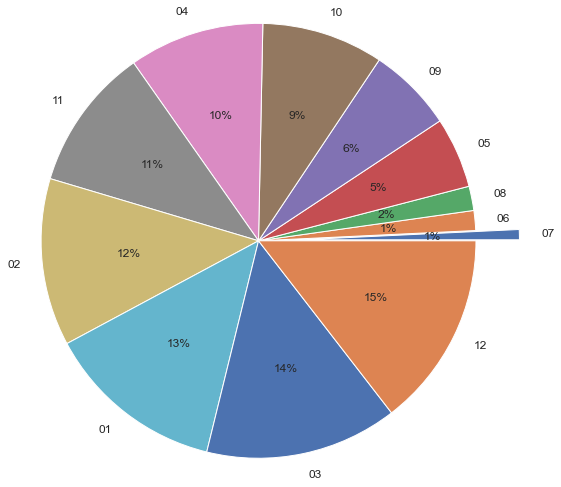

In [75]:
labels=temp.hour
props=temp.InvoiceNo
explode=(0.5, 0,0,0,0,0,0,0,0,0,0,0)
plt.pie(props,labels=labels ,autopct='%.0f%%',textprops={'size': 'medium'},shadow=False, radius=2.5,explode=explode)
plt.show()

In [21]:
location=data.Country.value_counts()
len(location.value_counts())

38

United kingdom has 350k+ customers all the other regions in blue have less than 50K customesrs.

In [25]:
import plotly.express as px
fig=px.choropleth(location, locations=location.index, locationmode='country names', color=location.values )
fig.show()

3. CUSTOMER ANALYSIS 
I'm using two methods to cluster/group customers.
i. Age monetary value and frequency 
This could classify customers in distinct clusters depending on business case.
LIFE = how long a customer has been in business with the retail shop. The stakeholders would come up with custom packages for older and new clients. New clients are more likely to churn out compared to older ones so a strategy eg discounts on every purchase would mantain them. 

Categorizing customers by purchase frequency would help map out customers by importance, this too would help in target marketing and preventing customer churn as well.

Grouping customers by monetary value would create a categories of most important and less important clients. The company therefore would focus more on the high value clients and at the same time encourage low value clients to buy more. 

Business Perspective:
The cost of mantaining existing clients is way low compared to the cost of obtaining new ones. Therefore, stakehholders would categorize customers by age and enhance target marketing. For instance, customers with life<10 days maybe termed as new and likely to churn out. 

A strategic approach is required to increase value of low value clients who would otherwise remain in this category or drop to a lower category. This would apply to all value groups. 

However I think using relative age, monetary value and frequency would be more accurate. Such that the life a customer is divided by the length of the campagain/study period. Consequently, monetary value and frequency should be divided by relative age. 

LOGIC: 
You cannot compare the value/frequency of an old(100 days) customer to a new(2 days) customer, this would give biased results. 

In [31]:
col=['CustomerID', 'InvoiceDate','InvoiceNo', 'total_value','Quantity']
temp=data[col]
#calculate age 
age=temp.groupby(['CustomerID']).agg(life=('InvoiceDate', lambda x: (max(x)-min(x))),
                                    worth=("total_value","sum"),
                                     Quantity=('Quantity','sum'),
                                frequency=('InvoiceDate','count'))
age.head()

,life,worth,Quantity,frequency
CustomerID,,,,
12346.0,0 days,19.76,19.0,2
12347.0,365 days,4310.00,2458.0,182
12348.0,283 days,1797.24,2341.0,31
12349.0,0 days,1757.55,631.0,73
12350.0,0 days,334.40,197.0,17


In [32]:
new_data=age.reset_index()

 4. CUSTOMER ANALYSIS USING K-MEANS ALGORITHM 

In [33]:
new_data.head(3)

,CustomerID,life,worth,Quantity,frequency
0,12346.0,0 days,19.76,19.0,2
1,12347.0,365 days,4310.00,2458.0,182
2,12348.0,283 days,1797.24,2341.0,31


In [34]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  8082 non-null   object         
 1   life        8082 non-null   timedelta64[ns]
 2   worth       8082 non-null   float64        
 3   Quantity    8082 non-null   float64        
 4   frequency   8082 non-null   int64          
dtypes: float64(2), int64(1), object(1), timedelta64[ns](1)
memory usage: 284.2+ KB


In [35]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [56]:
x=new_data.drop(['CustomerID','life'], axis=1)
x=scaler.fit_transform(x)
x

array([[-0.20211321, -0.1857673 , -0.35143376],
       [ 0.53860848,  0.5685685 ,  0.62099921],
       [ 0.10477358,  0.53238265, -0.194764  ],
       ...,
       [-0.20816642, -0.1922622 , -0.35683616],
       [-0.20724273, -0.19195292, -0.35683616],
       [-0.20724273, -0.19195292, -0.35683616]])

In [58]:
import sklearn.cluster as cluster

inertia = []
for i in range(2,10):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

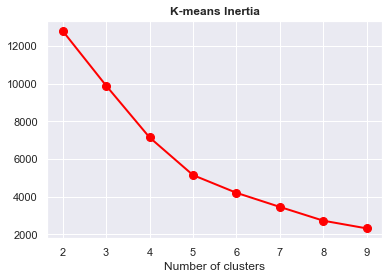

In [62]:
plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

In [66]:
#the optimum k groups is 5 -elbow method
kmeans = cluster.KMeans(n_clusters=5,random_state=17,init='k-means++')
kmeans_labels = kmeans.fit_predict(x)

centroids = kmeans.cluster_centers_

pd.Series(kmeans_labels).value_counts()

0    7479
3     587
1      11
4       4
2       1
dtype: int64

In [71]:
new=new_data.drop(['CustomerID','life'], axis=1)
centroids_data=pd.DataFrame(data=scaler.inverse_transform(centroids), columns=new.columns)
centroids_data

,worth,Quantity,frequency
0,570.316689,289.265811,37.956010
1,94809.108182,50326.727273,1029.272727
2,266599.600000,186503.000000,2085.000000
3,6457.304072,3346.608177,376.444634
4,63857.655000,34994.750000,5914.000000
